In [12]:
import numpy as np 
import pandas as pd 
import os
import keras.backend as K 
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In [13]:
# Import dataset
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

In [14]:
# Separate the training data based on labels
df1 = train_df[train_df['label'] == 'CE']
df2 = train_df[train_df['label'] == 'LAA']

# Adjust n to change number of CE data
sampled= df1.sample(n=200, random_state=42)
train_df = pd.concat([sampled, df2],ignore_index=True)

# Print the DataFrame
print("DataFrame:")
print(train_df.head())
train_df['label'].value_counts()

DataFrame:
   image_id  center_id patient_id  image_num label
0  4f6fb1_1         10     4f6fb1          1    CE
1  217b27_0         11     217b27          0    CE
2  a4e918_0         11     a4e918          0    CE
3  2745fc_0         11     2745fc          0    CE
4  aa2f56_0          9     aa2f56          0    CE


LAA    207
CE     200
Name: label, dtype: int64

## Data viusalization

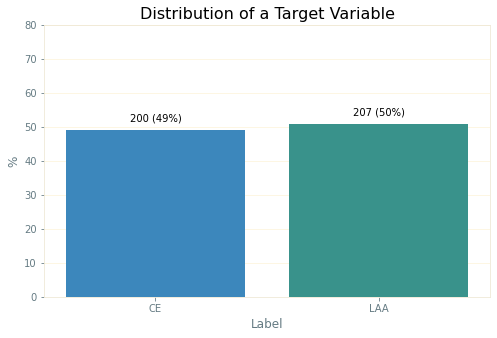

Train Size = 407
Test Size = 4


In [15]:
# Visualize the distribution of target variable

plt.style.use('Solarize_Light2')
label_percentages = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
label_counts = train_df['label'].value_counts()  

plt.figure(figsize=(8, 5), facecolor='white') 
bar_chart = sns.barplot(x=label_percentages.index, y=label_percentages.values)

bar_chart.set_facecolor('white')

plt.title("Distribution of a Target Variable")
plt.ylabel("%")
plt.xlabel("Label")

plt.ylim(0, 80)

for index, patch in enumerate(bar_chart.patches):
    label = label_percentages.index[index]
    count = label_counts[label]
    percentage = int(label_percentages[label])
    bar_chart.annotate(f'{count} ({percentage}%)',
                      (patch.get_x() + patch.get_width() / 2., patch.get_height() + 2),  
                      ha='center', va='bottom', fontsize=10)

plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))

In [16]:
# Load images
train_image = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_image = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")

# Display sizes of training and test datasets
print(f"Number of images in a training set: {len(train_image)}")
print(f"Number of images in a training set: {len(test_image)}")


Number of images in a training set: 754
Number of images in a training set: 4


In [17]:
image_metadata = defaultdict(list)

# Extract metadata from each training image
for idx, img_path in enumerate(train_image):
    img_path = train_image[idx]
    slide_obj = OpenSlide(img_path)    
    image_metadata['image_id'].append(img_path[-12:-4])
    image_metadata['width'].append(slide_obj.dimensions[0])
    image_metadata['height'].append(slide_obj.dimensions[1])
    image_metadata['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    image_metadata['path'].append(img_path)

image_df = pd.DataFrame(image_metadata)
image_df['img_aspect_ratio'] = image_df['width']/image_df['height']
image_df.sort_values(by='image_id', inplace=True)
image_df.reset_index(inplace=True, drop=True)

image_df = image_df.merge(train_df, on='image_id')
image_df.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
2,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
3,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE
4,028989_0,32789,85695,1721.26,/kaggle/input/mayo-clinic-strip-ai/train/02898...,0.382624,5,028989,0,LAA


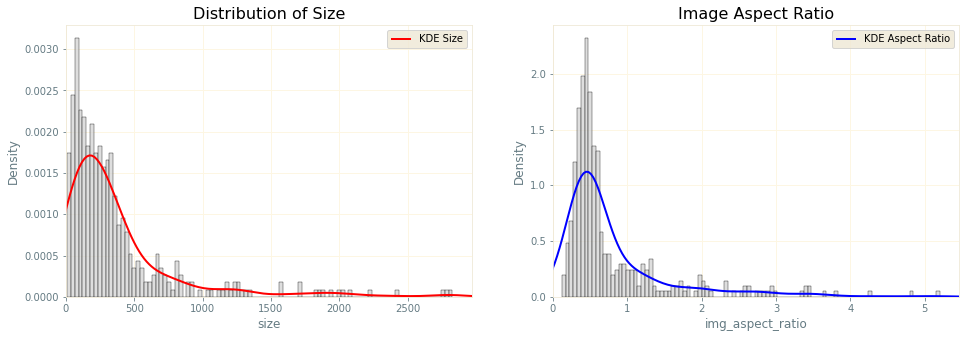

In [18]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(1, 2, figsize=(16, 5), facecolor='white')

sns.histplot(x='size', data=image_df, bins=100, ax=ax[0], stat='density', kde=False, color='lightgray')
ax[0].set_title("Distribution of Size")
ax[0].set_xlim(left=0)

sns.kdeplot(x='size', data=image_df, ax=ax[0], color='red', linewidth=2, label='KDE Size')
ax[0].legend()

sns.histplot(x='img_aspect_ratio', data=image_df, bins=100, ax=ax[1], stat='density', kde=False, color='lightgray')
ax[1].set_title("Image Aspect Ratio")
ax[1].set_xlim(left=0)

sns.kdeplot(x='img_aspect_ratio', data=image_df, ax=ax[1], color='blue', linewidth=2, label='KDE Aspect Ratio')
ax[1].legend()

for a in ax:
    a.set_facecolor('white')

plt.show()

In [19]:
# Increase max image pixels to avoid image warnings
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

# Separate file paths for classes
ce_image = image_df.loc[image_df['label']=='CE','path']
laa_image = image_df.loc[image_df['label']=='LAA','path']

## Loading Data

In [20]:
# Create file paths for training and test DataFrames
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [21]:
# Labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,4f6fb1_1,10,4f6fb1,1,CE,../input/mayo-clinic-strip-ai/train/4f6fb1_1.tif,1
1,217b27_0,11,217b27,0,CE,../input/mayo-clinic-strip-ai/train/217b27_0.tif,1
2,a4e918_0,11,a4e918,0,CE,../input/mayo-clinic-strip-ai/train/a4e918_0.tif,1
3,2745fc_0,11,2745fc,0,CE,../input/mayo-clinic-strip-ai/train/2745fc_0.tif,1
4,aa2f56_0,9,aa2f56,0,CE,../input/mayo-clinic-strip-ai/train/aa2f56_0.tif,1


## Preprocessing

In [22]:
# Function to preprocess each image (resize and read region)
import time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 407/407 [33:38<00:00,  4.96s/it]


In [23]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [24]:
#Splitting data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

#Splitting data into training and validation sets
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

## CNN Model

In [25]:
# Define a custom F1 score function for model evaluation
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [34]:
# Build a CNN model
from keras import metrics
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
model = Sequential()
input_shape = (128, 128, 4)

# Add convolutional layers followed by normalization and pooling
model.add(Conv2D(filters=128, kernel_size = (5,5), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (5,5), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size = (5,5), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=16, kernel_size = (1,1), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())

model.add(Dropout(0.2)) # Dropout to reduce overfitting
model.add(Flatten())

# Add fully connected layers
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.13))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-6))

## Balancing class weights

In [35]:
# Calculate balanced class weights for training
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.9830917874396136, 1: 1.0175}

## Training the model

In [36]:
# Set up callbacks for early stopping and model checkpointing
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Fit the model
model.fit(
    x_train,
    y_train,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1 
)

Epoch 1/100
11/11 [==============================] - 1s 52ms/step - loss: 0.7005 - binary_accuracy: 0.4523 - f1_score: 0.5673 - val_loss: 0.6923 - val_binary_accuracy: 0.5732 - val_f1_score: 0.7177
Epoch 2/100
11/11 [==============================] - 0s 30ms/step - loss: 0.6970 - binary_accuracy: 0.4585 - f1_score: 0.5195 - val_loss: 0.6919 - val_binary_accuracy: 0.5732 - val_f1_score: 0.7177
Epoch 3/100
11/11 [==============================] - 0s 30ms/step - loss: 0.6979 - binary_accuracy: 0.4892 - f1_score: 0.6159 - val_loss: 0.6914 - val_binary_accuracy: 0.5732 - val_f1_score: 0.7177
Epoch 4/100
11/11 [==============================] - 0s 30ms/step - loss: 0.7037 - binary_accuracy: 0.4585 - f1_score: 0.5430 - val_loss: 0.6908 - val_binary_accuracy: 0.5732 - val_f1_score: 0.7177
Epoch 5/100
11/11 [==============================] - 0s 30ms/step - loss: 0.7042 - binary_accuracy: 0.4400 - f1_score: 0.5688 - val_loss: 0.6902 - val_binary_accuracy: 0.5732 - val_f1_score: 0.7177
Epoch 6/10

# Model Result

In [37]:
# Load the best model and evaluating result
best_cnn = load_model('/kaggle/working/best_model.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

3/3 [==============================] - 0s 9ms/step - loss: 0.6847 - binary_accuracy: 0.5732 - f1_score: 0.7177


[0.6846827268600464, 0.5731707215309143, 0.7176656723022461]